Authors: Carles Toujouse & Astor Prieto.

# Computer vision - Laboratory

==============================================================================================
## Practicum 3: Image and Video Segmentation

==============================================================================================

The main topics are:

1)	Segmentation of video shots with static scenes.

2) Background substraction.

3)	Segmentation of images.

In order to successfuly complete this practicum it is necessary to understand the following theory concepts: background substraction, K-means clustering, etc.

The following chapters of the book “Computer Vision: Algorithms and Applicatons” from Richard Szeliski have further information about the topic:

* Chapter 4: Computer Vision: Algorithms and Applications.

* Chapter 5: Segmentation.

In [5]:
import numpy as np
import skimage
from skimage import io, color, filter, segmentation, img_as_float
import matplotlib.pyplot as plt

import matplotlib.animation as animation

## 3.1 Background substraction methods


Given the video stored in ‘Barcelona-sequence’, which contains images acquired by a static camera, remove all the "artifacts" considered as foreground related to movement extracting the background images.

Note: One of the applications of these methods is the button "remove tourists" implemented in most commercial photo cameras. For instance, Adobe uses the "Monument Mode", which automatically deletes the people going by the cameras.

Read and visualize the sequence of images "images/Barcelona-sequence"
Hint: In order to read a  collection of images, we wil use the function animation.FuncAnimation [https://matplotlib.org/2.0.0/api/_as_gen/matplotlib.animation.FuncAnimation.html].

Observe in the following example, how FuncAnimation is used to read and visualize a sequence of frames. Explore the parameters of animation.FuncAnimation().

<IPython.core.display.Javascript object>


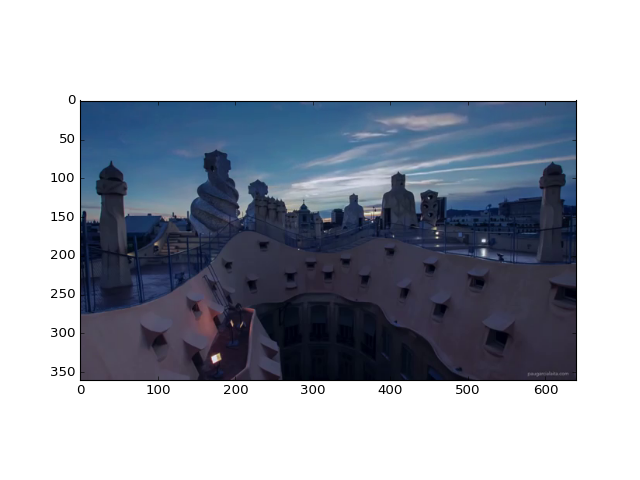

In [6]:
ic = io.ImageCollection('images/Barcelona-sequence/*.png')
        # Reading a sequence of images from a folder

%matplotlib nbagg 
    #Changing the pluggin is necessary always when visualizing a video!
    
i=0       #Inicializing the video display
fig = plt.figure()  # Create figure
im = plt.imshow(ic[i], animated=True) #Visualize the first image

def updatefig1(i):   #Updating the frame visualization
    im.set_array(ic[i*5]) #Changing the content of the canvas
    return im, #to return a tuple!

ani = animation.FuncAnimation(fig, updatefig1, interval=5, blit=False, frames=50, repeat= False)

a) Find where a shot (scene) finishes and the following starts (boundaries). Each of the scenes in a video is usually called 'shot'. Which measure can be used in order to visually distinguish the shots in a plot? Explain your solution.

Show the initial and final images of each shot extracted as follows:

<img src="images_for_notebook/result_shot_detection.png">

**Hint:** take the following example of video and temporal plot visualization as a template. The plot must be replaced by a frame by frame measure to be defined by you, being applicable to distinguish the shots.

- If you need to convert the image to float, the command is: img_as_float()
- If you need the histogram, it is in skimage.exposure

<IPython.core.display.Javascript object>


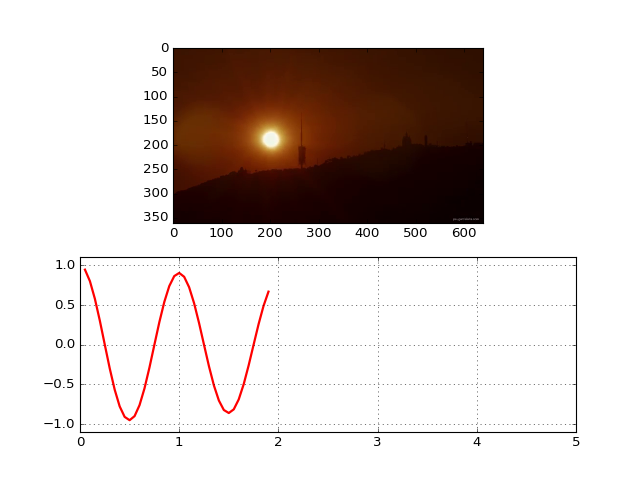

In [7]:
# Example
# Sinusoidal plot points generation
def data_gen():
    t = data_gen.t
    cnt = 0
    while cnt < 1000:
        cnt+=1
        t += 0.05
        y = np.cos(2*np.pi*t) * np.exp(-t/10.)
        # adapted the data generator to yield both sin and cos
        yield t, y

data_gen.t = 0

%matplotlib nbagg

# create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(2,1)

# intialize a line object on the second axes for plotting
line, = ax2.plot([], [], lw=2, color='r')

ax2.set_ylim(-1.1, 1.1)
ax2.set_xlim(0, 5)
ax2.grid()

# initialize the data arrays 
xdata, ydata = [], []
def run(data):
    # update the data plot
    t, y = data
    xdata.append(t) # time = x axis
    ydata.append(y) # y axis

    # Plot image on top row
    ax1.imshow(ic[len(xdata)])
          
    # Plot sin in bottom row
    xmin, xmax = ax2.get_xlim()
    if t >= xmax:
        ax2.set_xlim(xmin, 2*xmax)
        ax2.figure.canvas.draw()
            
    # update the data of both line objects
    line.set_data(xdata, ydata)

    return line

ani = animation.FuncAnimation(fig, run, data_gen, blit=True, interval=10, repeat=False)
plt.show()

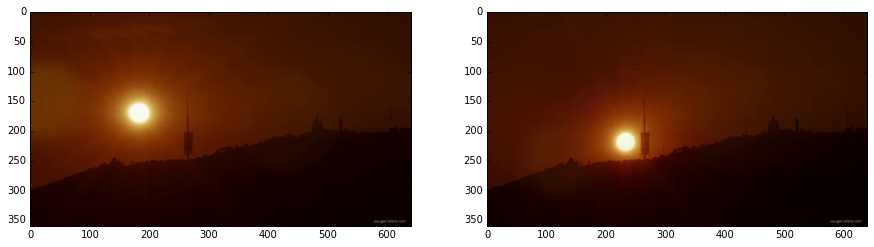

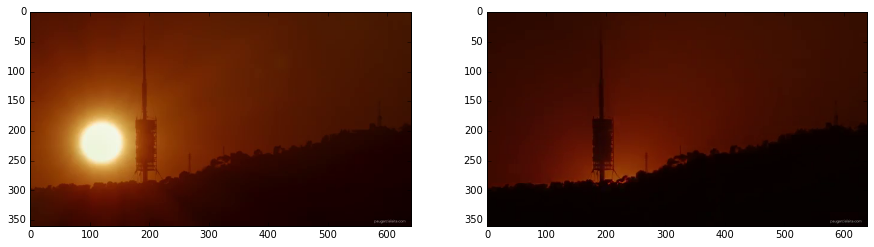

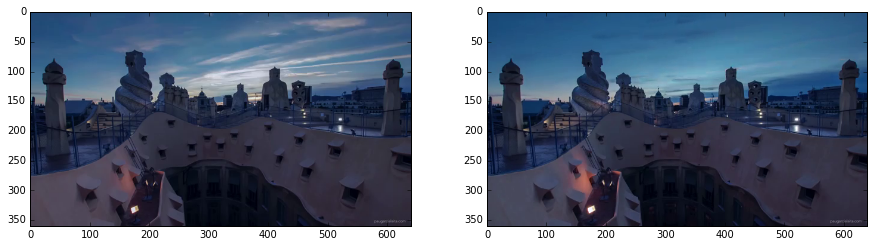

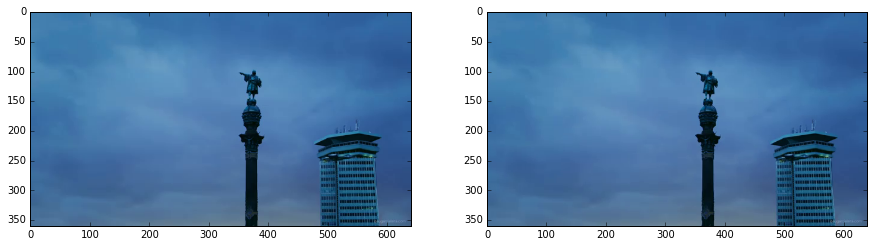

Minim difference between frames ::: 0.00245915223485
Maxim difference between frames ::: 105.983769583


In [8]:
# Method to compare different frame 'values'
def compare_frames(frame1, frame2):
    return np.sum(abs(frame1 - frame2))

def checkmin(value, minim):
    if(value < minim):
        minim = value
    return minim
    
def checkmax(value, maxim):
    if(value > maxim):
        maxim = value
    return maxim

%matplotlib inline
        
# Loading the image_collection and setting the Threshold value
ic = io.ImageCollection('images/Barcelona-sequence/*.png')

threshold = 10.0 # Threshold in which we detect the frame has changed scenes.
diff_min = 9999.0 # Minimal difference between frames, starts here
diff_max = 0.0 # Maximal difference between frames, starts here

# Computing Frame heuristic using frame_norm
frame_norms = []
for frame in ic:
    frame_norms.append(np.linalg.norm(color.rgb2gray(frame)))

final_col = [(ic[0], 0)] # Saves the original frame and it's position (index)
for i in range(1, len(frame_norms) - 1):
    diff = compare_frames(frame_norms[i - 1], frame_norms[i])
    diff_min = checkmin(diff, diff_min)
    diff_max = checkmax(diff, diff_max)
    if diff > threshold:
        final_col.append((ic[i - 1], i - 1))
        final_col.append((ic[i], i))
final_col.append((ic[-1], len(frame_norms) - 1))

# Show
fig1, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 5))
fig2, (ax3, ax4) = plt.subplots(ncols=2, figsize=(15, 5))
fig3, (ax5, ax6) = plt.subplots(ncols=2, figsize=(15, 5))
fig4, (ax7, ax8) = plt.subplots(ncols=2, figsize=(15, 5))

ax1.imshow((final_col[0][0]))
ax2.imshow((final_col[1][0]))
ax3.imshow((final_col[2][0]))
ax4.imshow((final_col[3][0]))
ax5.imshow((final_col[4][0]))
ax6.imshow((final_col[5][0]))
ax7.imshow((final_col[6][0]))
ax8.imshow((final_col[7][0]))

plt.show()

print('Minim difference between frames ::: ' + str(diff_min))
print('Maxim difference between frames ::: ' + str(diff_max))

"""
We compute the difference between frames using the 'norm' of each frame, when a certain threshold is exceeded,
we identfy the current frame as a NEW SCENE, and the frame before as the LAST FRAME of the last scene.
"""

## 3.2 Background substraction

Apply the background substraction algorithm (check theory material).

Visualize, for each shot of the video:
    1) images belonging to the shot
    2) the background image, and
    3) the foreground.
    
**Hint**: You can construct a mask obtained from the original image and the background in order to know which parts of the image form part from the foreground and recover from the original image just the foreground regions.

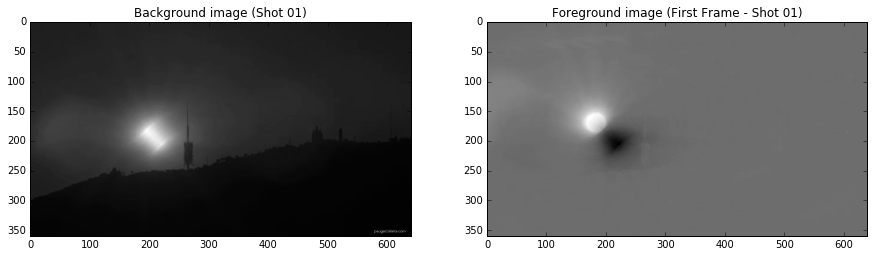

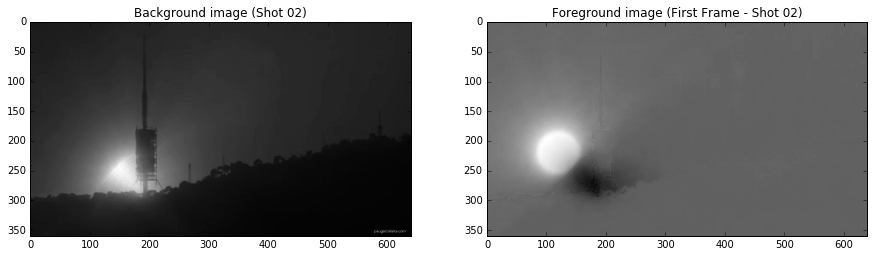

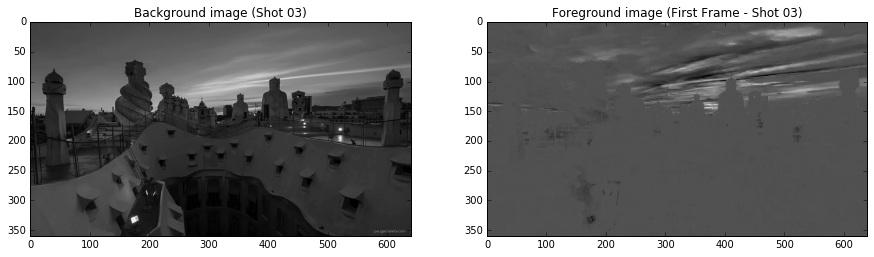

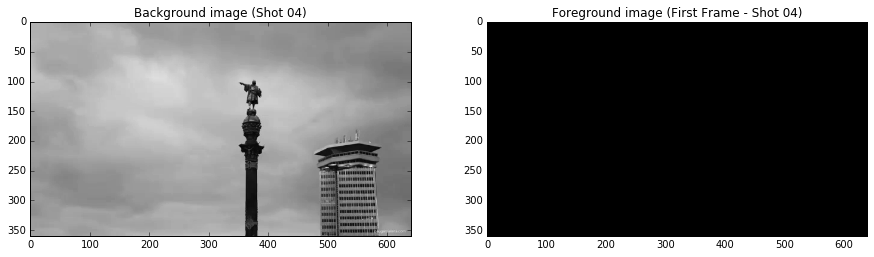

In [30]:
def toGray(scene):
    scene_gray = []
    for frame in scene:
        scene_gray.append(color.rgb2gray(frame))
    return scene_gray

#Return tuple (background, foreground) for x scene with y frame for the foreground substraction
def bgSubstraction(scene_idx, fg_frame):
    bg = np.median(toGray(scenes[scene_idx]), axis=0)
    fg = color.rgb2gray(scenes[scene_idx][fg_frame]) - bg
    return (bg, fg) 

%matplotlib inline

ic = io.ImageCollection('images/Barcelona-sequence/*.png')

# Data to process (separated in scenes)
scenes = [[], [], [], []]
scenes_idx = [(0, 1), (2, 3), (4, 5), (6, 7)]
sel_scene = 0
idx = 0

# Saving each frame of the collection in different 'scenes'
for i in range(0, len(scenes)):
    for j in range(final_col[scenes_idx[i][0]][1], final_col[scenes_idx[i][1]][1]):
        scenes[i].append(ic[j])

# Calculate background/foreground substraction for each scene
medians = []
foregrounds = []
for i in range (0,len(scenes)):
    median, foreground = bgSubstraction(i,0)
    medians.append(median)
    foregrounds.append(foreground)

# Show
fig1, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 10))
fig2, (ax3, ax4) = plt.subplots(ncols=2, figsize=(15, 10))
fig3, (ax5, ax6) = plt.subplots(ncols=2, figsize=(15, 10))
fig4, (ax7, ax8) = plt.subplots(ncols=2, figsize=(15, 10))

ax1.imshow(medians[0], cmap='gray')
ax2.imshow(foregrounds[0], cmap='gray')
ax3.imshow(medians[1], cmap='gray')
ax4.imshow(foregrounds[1], cmap='gray')
ax5.imshow(medians[2], cmap='gray')
ax6.imshow(foregrounds[2], cmap='gray')
ax7.imshow(medians[3], cmap='gray')
ax8.imshow(foregrounds[3], cmap='gray')

ax1.set_title('Background image (Shot 01)')
ax2.set_title('Foreground image (First Frame - Shot 01)')
ax3.set_title('Background image (Shot 02)')
ax4.set_title('Foreground image (First Frame - Shot 02)')
ax5.set_title('Background image (Shot 03)')
ax6.set_title('Foreground image (First Frame - Shot 03)')
ax7.set_title('Background image (Shot 04)')
ax8.set_title('Foreground image (First Frame - Shot 04)')

plt.show()

Comment your implementation including details. What happens if the shots are not correctly extracted? What happens if you find too many shots in the video? What do the static background images represent? In which situations does the algorithm work and in which it does not? What happens if you substract the background image from the original one?

Do you see any additional application for this algorithm?

**[OPTIONAL]**
Apply the algorithm to some other static video that you found.

In [17]:
print('First of all, we identify the shots of each scene, using the difference between frames.')
print('Then we get and save the frames of each scene, and using the "bgSubtraction()" method,')
print('we save the "background" image (using median substraction) and "foreground" image (as the difference of')
print('an original frame and the Background).')
print('')
print('The second parameter of "bgSubstraction()" lets us choose which Frame will be used for getting its foreground.')
print('')
print('The Background image represents the most invariant pixels in the series of images of the scene (static),')
print('for that reason we cannot apply this method to non-static scenes (ex. camera moving).')
print('Substracting the BG image from any frame lets us see the less static pixels of the frame (aka. foreground elements).')

First of all, we identify the shots of each scene, using the difference between frames.
Then we get and save the frames of each scene, and using the "bgSubtraction()" method,
we save the "background" image (using median substraction) and "foreground" image (as the difference of
an original frame and the Background).

The second parameter of "bgSubstraction()" lets us choose which Frame will be used for getting its foreground.

The Background image represents the most invariant pixels in the series of images of the scene (static),
for that reason we cannot apply this method to non-static scenes (ex. camera moving).
Substracting the BG image from any frame lets us see the less static pixels of the frame (aka. foreground elements).


## 3.3 Clustering methods on the RGB-XY space

a) Read any image from the folder 'images' and segment it using Felzenszwalbs's method. Test different parameters in order to obtain a good image segmentation. How does each parameter behave? Which are the optimal values? Comment what algorithm is the method based in up to 3 lines most.

**Hint**: 
- Different image segmentation commands can be found in skimage.segmentation.
- Use the function segmentation.mark_boundaries for seeing the boundaries of the segments.
- Use the inline pluggin to visualize images (%matplotlib inline)
- Add title to the figures to explain what is displayed.

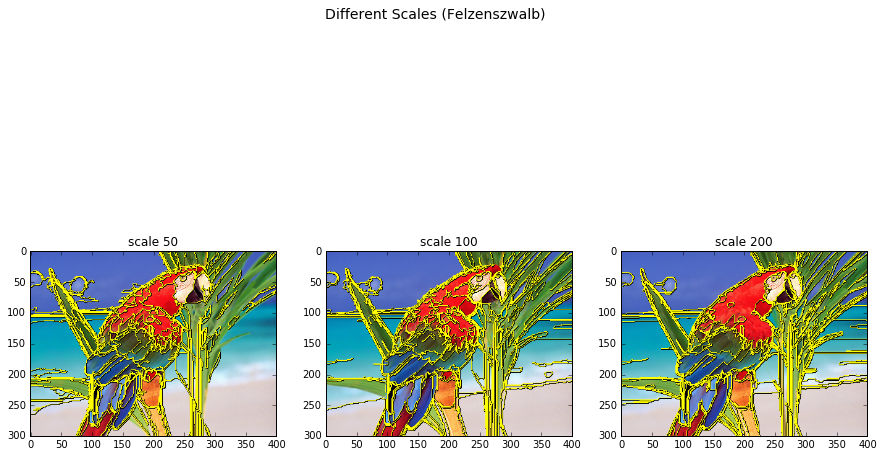

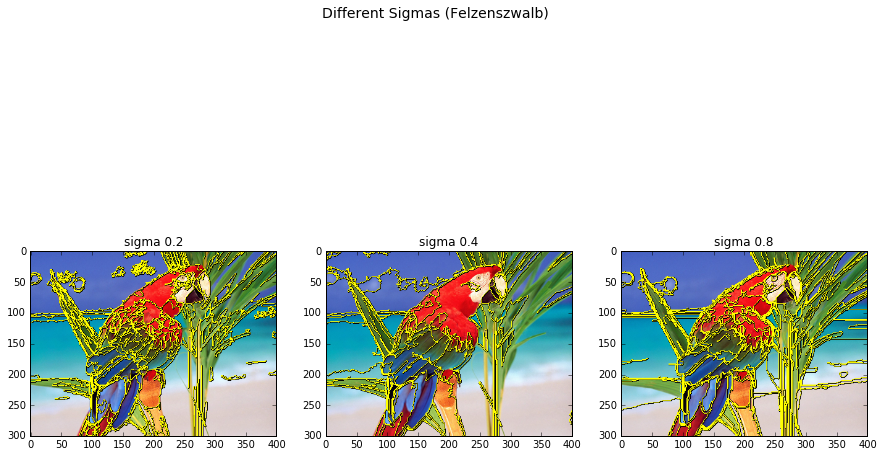

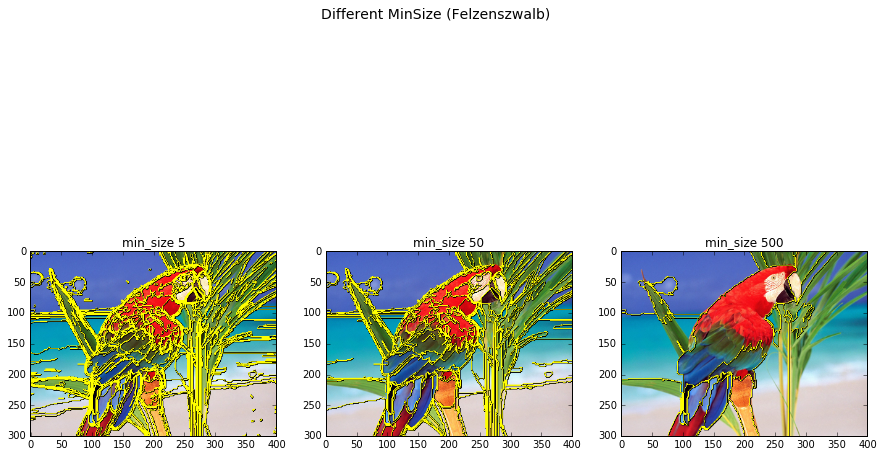

In [21]:
image = io.imread('images/loro.png')

%matplotlib inline

# Segmenting using Felzenszwalb w/ different scales
segments_fz_01 = segmentation.felzenszwalb(image, scale=50, sigma=0.8, min_size=50)
segments_fz_02 = segmentation.felzenszwalb(image, scale=100, sigma=0.8, min_size=50)
segments_fz_03 = segmentation.felzenszwalb(image, scale=200, sigma=0.8, min_size=50)

# Segmenting using Felzenszwalb w/ different sigmas
segments_fz_04 = segmentation.felzenszwalb(image, scale=100, sigma=0.2, min_size=50)
segments_fz_05 = segmentation.felzenszwalb(image, scale=100, sigma=0.4, min_size=50)
segments_fz_06 = segmentation.felzenszwalb(image, scale=100, sigma=0.8, min_size=50)

# Segmenting using Felzenszwalb w/ different min_size
segments_fz_07 = segmentation.felzenszwalb(image, scale=100, sigma=0.8, min_size=5)
segments_fz_08 = segmentation.felzenszwalb(image, scale=100, sigma=0.8, min_size=50)
segments_fz_09 = segmentation.felzenszwalb(image, scale=100, sigma=0.8, min_size=500)

# Show
fig1, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(15, 10))
fig2, (ax3, ax4, ax5) = plt.subplots(ncols=3, figsize=(15, 10))
fig3, (ax6, ax7, ax8) = plt.subplots(ncols=3, figsize=(15, 10))

fig1.suptitle('Different Scales (Felzenszwalb)', fontsize=14)
ax0.set_title('scale 50')
ax1.set_title('scale 100')
ax2.set_title('scale 200')

ax0.imshow(segmentation.mark_boundaries(image, segments_fz_01))
ax1.imshow(segmentation.mark_boundaries(image, segments_fz_02))
ax2.imshow(segmentation.mark_boundaries(image, segments_fz_03))

fig2.suptitle('Different Sigmas (Felzenszwalb)', fontsize=14)
ax3.set_title('sigma 0.2')
ax4.set_title('sigma 0.4')
ax5.set_title('sigma 0.8')

ax3.imshow(segmentation.mark_boundaries(image, segments_fz_04))
ax4.imshow(segmentation.mark_boundaries(image, segments_fz_05))
ax5.imshow(segmentation.mark_boundaries(image, segments_fz_06))

fig3.suptitle('Different MinSize (Felzenszwalb)', fontsize=14)
ax6.set_title('min_size 5')
ax7.set_title('min_size 50')
ax8.set_title('min_size 500')

ax6.imshow(segmentation.mark_boundaries(image, segments_fz_07))
ax7.imshow(segmentation.mark_boundaries(image, segments_fz_08))
ax8.imshow(segmentation.mark_boundaries(image, segments_fz_09))

plt.show()

b) Segment the previous image using SLIC algorithm. Test different parameters in order to obtain a good image segmentation. How does each parameter behave? Upt o your opinion, which are the optimal values? Comment what algorithm is the method based in up to 3 lines.

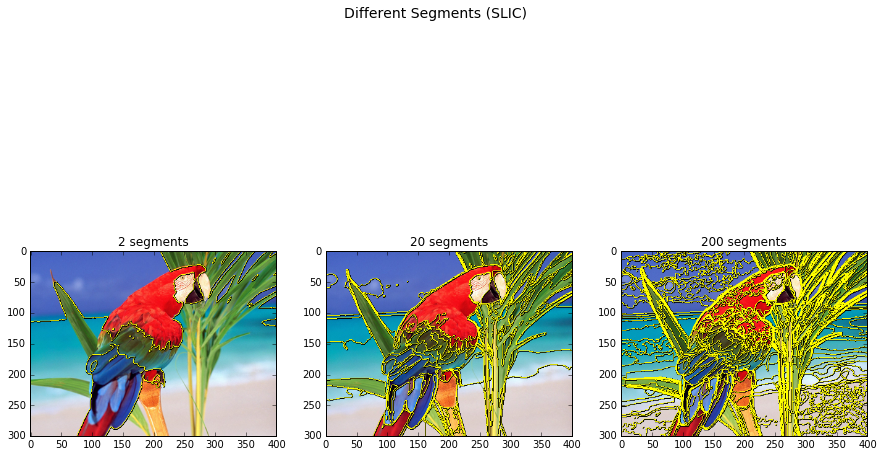

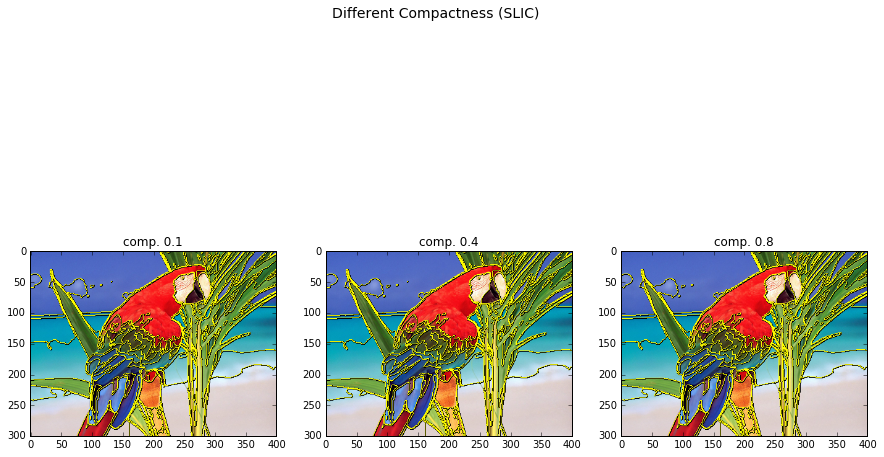

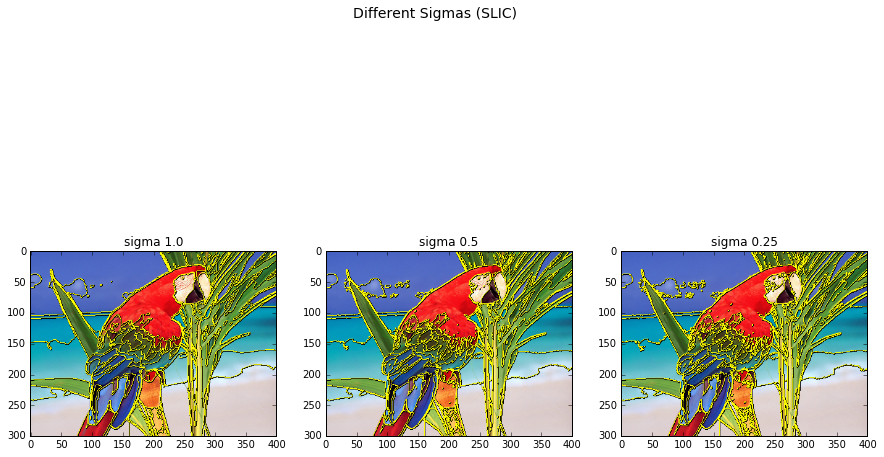

In [22]:
image = io.imread('images/loro.png')

%matplotlib inline

# Segmenting using SLIC w/ different segments
segments_slic_01 = segmentation.slic(image, n_segments=2, compactness=0.1, sigma=1)
segments_slic_02 = segmentation.slic(image, n_segments=20, compactness=0.1, sigma=1)
segments_slic_03 = segmentation.slic(image, n_segments=200, compactness=0.1, sigma=1)

# Segmenting using SLIC w/ different compactness
segments_slic_04 = segmentation.slic(image, n_segments=20, compactness=0.1, sigma=1)
segments_slic_05 = segmentation.slic(image, n_segments=20, compactness=0.4, sigma=1)
segments_slic_06 = segmentation.slic(image, n_segments=20, compactness=0.8, sigma=1)

# Segmenting using SLIC w/ different sigmas
segments_slic_07 = segmentation.slic(image, n_segments=20, compactness=0.1, sigma=1)
segments_slic_08 = segmentation.slic(image, n_segments=20, compactness=0.1, sigma=0.5)
segments_slic_09 = segmentation.slic(image, n_segments=20, compactness=0.1, sigma=0.25)

# Show
fig1, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(15, 10))
fig2, (ax3, ax4, ax5) = plt.subplots(ncols=3, figsize=(15, 10))
fig3, (ax6, ax7, ax8) = plt.subplots(ncols=3, figsize=(15, 10))

fig1.suptitle('Different Segments (SLIC)', fontsize=14)
ax0.set_title('2 segments')
ax1.set_title('20 segments')
ax2.set_title('200 segments')

ax0.imshow(segmentation.mark_boundaries(image, segments_slic_01))
ax1.imshow(segmentation.mark_boundaries(image, segments_slic_02))
ax2.imshow(segmentation.mark_boundaries(image, segments_slic_03))

fig2.suptitle('Different Compactness (SLIC)', fontsize=14)
ax3.set_title('comp. 0.1')
ax4.set_title('comp. 0.4')
ax5.set_title('comp. 0.8')

ax3.imshow(segmentation.mark_boundaries(image, segments_slic_04))
ax4.imshow(segmentation.mark_boundaries(image, segments_slic_05))
ax5.imshow(segmentation.mark_boundaries(image, segments_slic_06))

fig3.suptitle('Different Sigmas (SLIC)', fontsize=14)
ax6.set_title('sigma 1.0')
ax7.set_title('sigma 0.5')
ax8.set_title('sigma 0.25')

ax6.imshow(segmentation.mark_boundaries(image, segments_slic_07))
ax7.imshow(segmentation.mark_boundaries(image, segments_slic_08))
ax8.imshow(segmentation.mark_boundaries(image, segments_slic_09))

plt.show()

c) Plot the original image and the results of both algorithms in a 1x3 subplot. Calculate also the number of segments obtained on the image by each of the algorithms. Comment the differences between each method as well as their advantages and disadvantages.

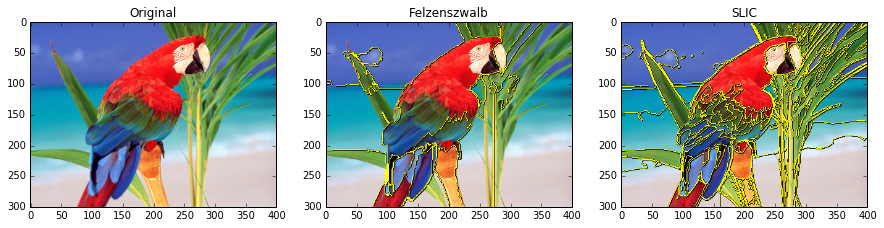

In [12]:
fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(15, 10))

ax0.imshow(image)
ax1.imshow(segmentation.mark_boundaries(image, segments_fz_09))
ax2.imshow(segmentation.mark_boundaries(image, segments_slic_04))

ax0.set_title('Original')
ax1.set_title('Felzenszwalb')
ax2.set_title('SLIC')

plt.show()

In [ ]:
"""
--- Felzenszwalb:

Computes Felsenszwalb’s efficient graph based image segmentation.

Produces an oversegmentation of a RGB image using a minimum spanning tree based clustering on the image grid. 
The parameter 'scale' sets an observation level. Higher scale means less and larger segments. 
'sigma' is the diameter of a Gaussian kernel, used for smoothing the image prior to segmentation.
The number of produced segments as well as their size can only be controlled indirectly through scale. 
Segment size within an image can vary greatly depending on local contrast.
For RGB images, the algorithm uses the euclidean distance between pixels in color space.

"""

"""
--- SLIC (Simple Linear Iterative Clustering)

Segments an image using k-means clustering in RGB-(x,y,z) space.
This algorithm simply performs K-means in the 5d space of color information and image location. 
As the clustering method is simpler, it is very efficient. 
It is essential for this algorithm to work in Lab color space to obtain good results. 
The 'compactness' parameter trades off color-similarity and proximity, while n_segments chooses the number of centers for kmeans.

"""